# Using Ordinary Least Squares Regression  to predict Co2 emissions based on number of engine cylinders

## Using dummy variables to represent ordered categorical values

This project is adapted from Source:https://timeseriesreasoning.com/contents/dummy-variables-in-a-regression-model/  

This notebook uses a historical dataset to build a linear regression model that predicts Co2 emissions based on number of cylinders in the engine.

## Project Objective
The purpose of this project is to predict Co2 emissions based on number of cylinders in the engine. 

## Model Design

The data set has vehicles with 2, 3, 4, 5, 6, 8, 10, 12 and 16 cylinders.

The number of cylinders is an integer variable, and it could be modelled as follows:

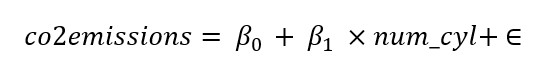

However this would be a serious error because the model would estimate a constant change in CO2 emissions for each unit change in the number of cylinders. 

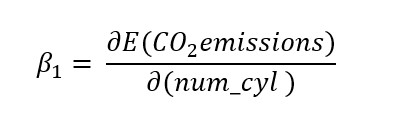

The model would estimate the difference in CO2 emissions between a 2 and 4 cylinder engine to be the same as between and 4 and 6 cylinder engine which is unlikely to be correct.

A more precise model would be one where the number of cylinders is treated as ordered categorical values with each value for the number of cylinders being represented by a dummy variable.

The project will build a model where the number of cylinders is treated as an ordered categorical variable with the number of cylinders being represented by a dummy variable. 


The updated model is shown below:

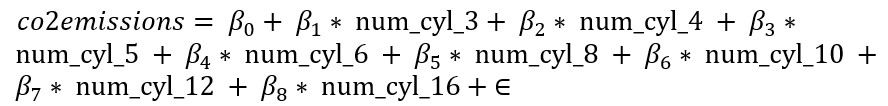

The dummy variable  for *num_of_cyl_2* has been dropped to prevent perfect collinearity with the other cyl variables. 

The intercept β0 will capture the coefficient for num_of_cyl_2. The coefficients of the other cylinder variables will contain the estimated deviation of co2 emissions compared to the co2emissions of 2 cylinder vehicles.

Model design adapted from Source:https://timeseriesreasoning.com/contents/dummy-variables-in-a-regression-model/


## 1. Collect the Data  
  
The process starts with importing the Panda’s and numpy packages.  
Next import the data into a Pandas data frame and preview the data frame.  

In [21]:
import pandas as pd # used to "tidy" up and manipulate our data
import numpy as np # used for matrix and numerical calculations; foundation of pandas
import matplotlib.pyplot as plt # used for visualisations
%matplotlib inline
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR') # error handling
import seaborn as sns # a more user-friendly library used for visualisations
sns.set_theme(rc={'figure.figsize':(8,6)})
import statistics
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as smf
from scipy.stats import pearsonr # import pearsonr function to calculate  Pearson correlation coefficient

In [22]:
dfr = pd.read_excel("C:/Users/ke337467/OneDrive - Oxfordshire County Council/Data Scientist Apprenticeship/Module Portfolio - Data Science Professional Practice/Vehicles/Vehicles_Power.xlsx")

Use the <span style="color:green">.head() method </span>which provides a concise summary of the data frame. 

In [23]:
dfr.head()

,citympg,cylinders,highwaympg,transmissiontype,co2emissions
0,14.0,6,19.0,Automatic,555.438
1,14.0,8,20.0,Automatic,555.438
2,18.0,8,26.0,Automatic,484.762
3,21.0,6,31.0,Automatic,424.167
4,14.0,8,19.0,Automatic,555.438


The dataset has five columns.  `citympg`, `cylinders`, `highwaympg`, `transmissiontype` and `co2emissions`. `cylinders` which will be convereted into one variable per cylinder category (9 cylinder variations) are the predictors (or independent variables), while `co2emissions`  is the response (or dependent variable).

However not need all these fields are needed so drop  `citympg`, `highwaympg` and `transmissiontype`

The dataset has missing values in `citympg` and `highwaympg` but fields are not required at the moment so we will leave them in place as the number of cylinders is available.

Next remove any variables that are not required or this model namely `citympg`, `highwaympg` and `transmissiontype`.

In [24]:
df = dfr.drop(columns = ['citympg','highwaympg', 'transmissiontype'], inplace=True)

In [25]:
#Add dummy variable columns to represent num_of_cyl
df = pd.get_dummies(data=dfr, columns=['cylinders'])

In [26]:
df.head()

,co2emissions,cylinders_2,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,cylinders_10,cylinders_12,cylinders_16
0,555.438,0,0,0,0,1,0,0,0,0
1,555.438,0,0,0,0,0,1,0,0,0
2,484.762,0,0,0,0,0,1,0,0,0
3,424.167,0,0,0,0,1,0,0,0,0
4,555.438,0,0,0,0,0,1,0,0,0


## 2. Tidy up the data set
Check the data set for any missing data

In [27]:
df.isnull().sum(axis=0)

co2emissions    0
cylinders_2     0
cylinders_3     0
cylinders_4     0
cylinders_5     0
cylinders_6     0
cylinders_8     0
cylinders_10    0
cylinders_12    0
cylinders_16    0
dtype: int64

<span style="color:red">**Note :**</span>  there are no fields within the dataset for this model that have missing data 

## 2. Explore the Data
A concise summary data tructure by calling the info() method.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36979 entries, 0 to 36978
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   co2emissions  36979 non-null  float64
 1   cylinders_2   36979 non-null  uint8  
 2   cylinders_3   36979 non-null  uint8  
 3   cylinders_4   36979 non-null  uint8  
 4   cylinders_5   36979 non-null  uint8  
 5   cylinders_6   36979 non-null  uint8  
 6   cylinders_8   36979 non-null  uint8  
 7   cylinders_10  36979 non-null  uint8  
 8   cylinders_12  36979 non-null  uint8  
 9   cylinders_16  36979 non-null  uint8  
dtypes: float64(1), uint8(9)
memory usage: 614.0 KB


There are 36,978 instances (or rows) in the dataset.

The dataset consists of 13 features (or columns). 

Summary statistics for the numeric features in the data by calling the describe() method.

In [29]:
df.describe()

,co2emissions,cylinders_2,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,cylinders_10,cylinders_12,cylinders_16
count,36979.000000,36979.000000,36979.000000,36979.000000,36979.000000,36979.000000,36979.000000,36979.000000,36979.000000,36979.000000
mean,476.550741,0.001325,0.006274,0.370994,0.019741,0.357446,0.224100,0.004137,0.015739,0.000243
std,117.791379,0.036378,0.078960,0.483077,0.139111,0.479254,0.416994,0.064191,0.124464,0.015599
min,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,400.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,467.737000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,555.438000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1269.571000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<span style="color:red">**Note :**</span>  there are no discernible outliers within the dataset

Text(0, 0.5, 'No. of Vehicles')

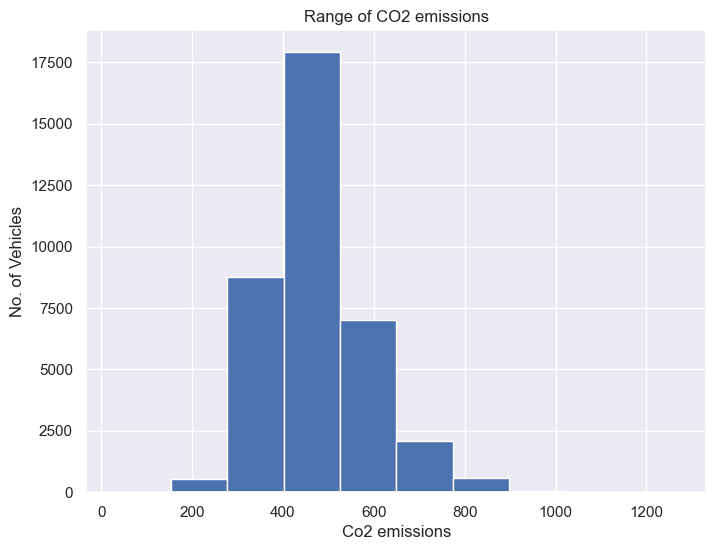

In [30]:
Co2 = df["co2emissions"].hist(bins=10)
#title of the histogram
Co2.set_title("Range of CO2 emissions")
#x-axis title
Co2.set_xlabel("Co2 emissions")
#y-axis title
Co2.set_ylabel("No. of Vehicles")


### 2.2 Verifying the correlation between the predictors and response variables

#### 2.2.1 Correlation between CO2 emissions and 8 cylinder engine

In [31]:
htc = pearsonr(df['cylinders_8'], df['co2emissions'])
htc

PearsonRResult(statistic=0.5805771664154546, pvalue=0.0)

#### 2.2.2. Observations
Pearson correlation coefficient (r) =  0.5806 indicates a moderate positive correlation between an eight cylinder engine ['cylinders_8'] and CO2 emissions ['co2emissions'].

Two-tailed p-value (p) = 0.0 being less than the level of significance  p < 0.05 indicates that there is a statistically significant association between an eight cylinder engine ['cylinders_8'] and CO2 emissions ['co2emissions'].


## 3. Prepare the Data for the data model

#### 3.1. Create the training and testing data sets.

In [32]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=29686
Testing data set length=7293


#### 3.2. Setup the regression expression
This expression is telling patsy that `co2emissions` is the response variable and the predictor variables are `cylinders_3`, `cylinders_4`, `cylinders_5`, `cylinders_6`, `cylinders_8`, `cylinders_10`, `cylinders_12`and `cylinders_16`

In [33]:
expr = 'co2emissions ~ cylinders_3 + cylinders_4 + cylinders_5 + cylinders_6 + cylinders_8'\
            '+ cylinders_10 + cylinders_12 + cylinders_16'

#### 3.3. Create the train and test data sets
Set up the x and y matrices for the training and testing data sets. Patsy makes this really simple

In [34]:
y_train, x_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, x_test = dmatrices(expr, df_test, return_type='dataframe')

### 4.1. Training the Ordinary Least Squares Regression model 
Use the `statsmodels GLM class` class from the `statsmodels` package to train the model.

In [35]:
model = smf.OLS(y_train, x_train).fit()

In [36]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           co2emissions   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     5190.
Date:                Tue, 14 Jan 2025   Prob (F-statistic):               0.00
Time:                        15:48:17   Log-Likelihood:            -1.7072e+05
No. Observations:               29686   AIC:                         3.415e+05
Df Residuals:                   29677   BIC:                         3.415e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      456.7646     11.743     38.896   

### 5. Interpreting the model output on the training data

Adjusted R-squared = `0.587` the number of cylinders in a vehicle appears to explain `58.7%` of the variance in CO2 emissions.  

The p-value of the F-statistic is `0.00` and therefore less than `0.001` indicating that all the regression variables in the model are jointly highly significant.  

#### 2 cylinder engines
The regression intercept (2 cylinder engine).   
The estimated mean CO2 emissions of 2 cylinder engines is 
`454.1906`.   
This estimate is statistically significant with a p-value of `0.000`   
The confidence level is `95%`  

#### 3 cylinder engines
The estimated CO2 emissions of 3 cylinder engines is 
`454.1906  - 197.8078 = 256.3828`.   
This estimate is statistically significant with a p-value of `0.000`.   
The confidence level is `95%`  

#### 4 cylinder engines
The estimated CO2 emissions of 4 cylinder engines is 
`454.1906  - 70.9128 = 383.2778`  
This estimate is statistically significant with a p-value of `0.000`.   
The confidence level is `95%`  

#### 5 cylinder engines
The estimated CO2 emissions of 5 cylinder engines is 
`454.1906  -8.3389 = 445.8517`  
This estimate is not statistically significant with a p-value of `0.501`.   
With a p-value of `0.501`, the significance of this estimate is valid only at a confidence level of `(1 — .501)100% = 49.9%`.  
The confidence level is only at `49.9%`  

#### 6 cylinder engines
The estimated CO2 emissions of 6 cylinder engines is 
`454.1906 + 32.159 = 486.3496`  
This estimate is statistically significant with a p-value of `0.007`.   
The confidence level is `95%`  

#### 8 cylinder engines
The estimated CO2 emissions of 8 cylinder engines is 
`454.1906 + 150.8186 = 605.0092`  
This estimate is statistically significant with a p-value of `0.000`.   
The confidence level is `95%`  

#### 10 cylinder engines
The estimated CO2 emissions of 10 cylinder engines is 
`454.1906 + 197.6213 = 651.8119`  
This estimate is statistically significant with a p-value of `0.000`.   
The confidence level is `95%`  

#### 12 cylinder engines
The estimated CO2 emissions of 12 cylinder engines is 
`454.1906 + 240.2122 = 694.4028`  
This estimate is statistically significant with a p-value of `0.000`.   
The confidence level is `95%`  

#### 16 cylinder engines
The estimated CO2 emissions of 16 cylinder engines is 
`454.1906 + 415.1982 = 869.3888`  
This estimate is statistically significant with a p-value of `0.000`.   
The confidence level is `95%`  

### 6. Conclusion

The estimated means CO2 emissions  of 3, 4, 6, 8, 10, 12 and 16-cylinder engines are all highly significant.  

The 5-cylinder engine is the only exception which appears to be less significant than all the other engines.   
  
The 16 cylinder engine with their estimated mean emissions of `869.3888` is nearly double the emissions of a 2 cylinder engine.           

From the analysis above it is clear that engine  CO2 emissions  do not change by a constant amount with each unit change in the number of cylinders. This vindicates the initial decision not to represent the number of cylinders as a simple integer-valued variable.  

In [37]:
coefficients = model.params
coeff_df = pd.DataFrame(coefficients, columns=['Coefficient'])
coeff_df.head

<bound method NDFrame.head of               Coefficient
Intercept      456.764595
cylinders_3   -199.428601
cylinders_4    -72.931308
cylinders_5    -12.168994
cylinders_6     30.091334
cylinders_8    146.882608
cylinders_10   194.255884
cylinders_12   239.944455
cylinders_16   410.210405>

### 7. Equation of the fitted model

Below is the equation for the fitted model:

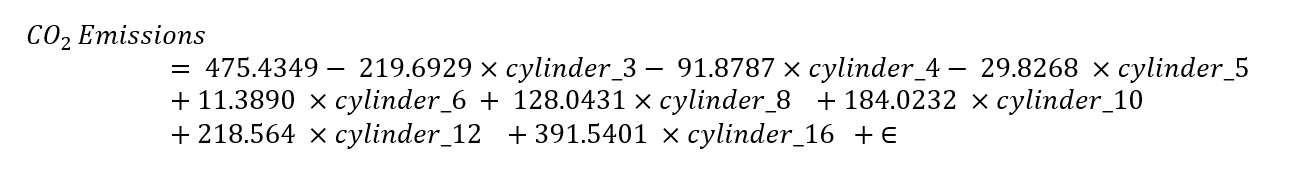